In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
plt.style.use('bmh')
from scipy import stats as ss
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

# the big boy stuff
import tensorflow.keras.metrics as metric
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
n = 500 # number of students
def grades(lower, upper, mean, std, n=n): # get an array of grades in a range and distribution parameters
    return [int(x) for x in (ss.truncnorm.rvs(((lower - mean) / std), ((upper - mean) / std), loc=mean, scale=std, size=n))]

### Gathering grades
#### Labs

In [3]:
Lab = dict()
for _ in range(1, 9):
    Lab[_] = grades(0, 10, 7, 3)
for key, item in Lab.items():
    print(f"Lab {key} -> {item[:10]}")

Lab 1 -> [5, 6, 9, 6, 4, 7, 4, 8, 8, 5]
Lab 2 -> [5, 4, 9, 3, 5, 2, 4, 8, 8, 4]
Lab 3 -> [7, 5, 5, 8, 5, 2, 5, 5, 8, 6]
Lab 4 -> [9, 3, 7, 7, 9, 8, 8, 2, 1, 7]
Lab 5 -> [5, 5, 6, 4, 2, 5, 9, 5, 7, 5]
Lab 6 -> [1, 5, 9, 6, 5, 6, 0, 5, 8, 5]
Lab 7 -> [8, 7, 3, 9, 0, 8, 6, 6, 3, 9]
Lab 8 -> [4, 8, 6, 4, 5, 2, 4, 7, 1, 7]


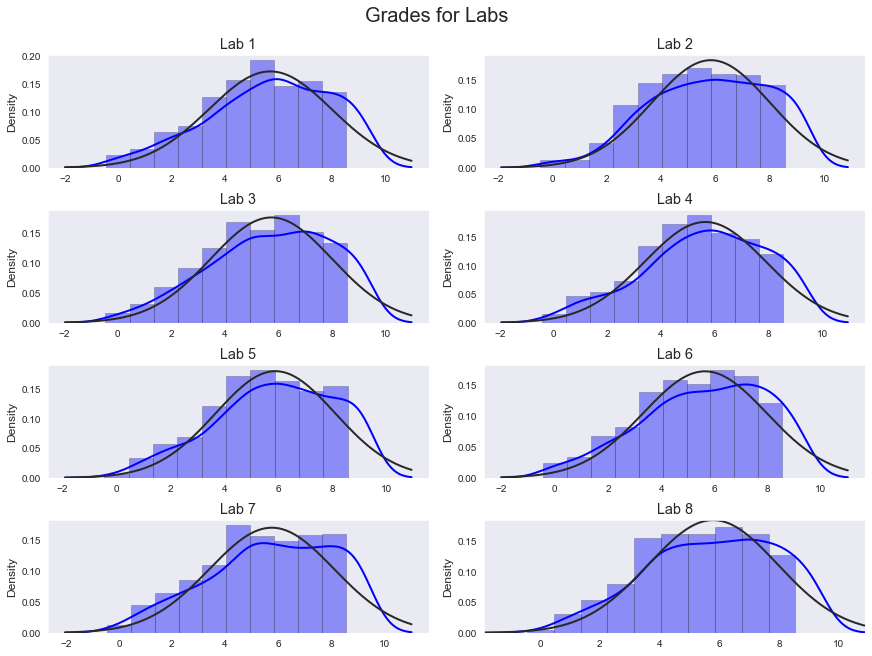

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(12, 9))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(8):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Lab[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Lab {_+1}")
fig.suptitle('Grades for Labs', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Assignments 

In [5]:
Assignment = dict()
for _ in range(1, 5):
    Assignment[_] = grades(0, 10, 7, 3)
for key, item in Assignment.items():
    print(f"Assignment {key} -> {item[:10]}")

Assignment 1 -> [5, 5, 2, 6, 6, 9, 5, 4, 7, 8]
Assignment 2 -> [8, 3, 7, 8, 4, 7, 7, 3, 6, 4]
Assignment 3 -> [8, 7, 6, 8, 4, 6, 4, 7, 7, 7]
Assignment 4 -> [6, 5, 7, 3, 5, 2, 3, 6, 9, 4]


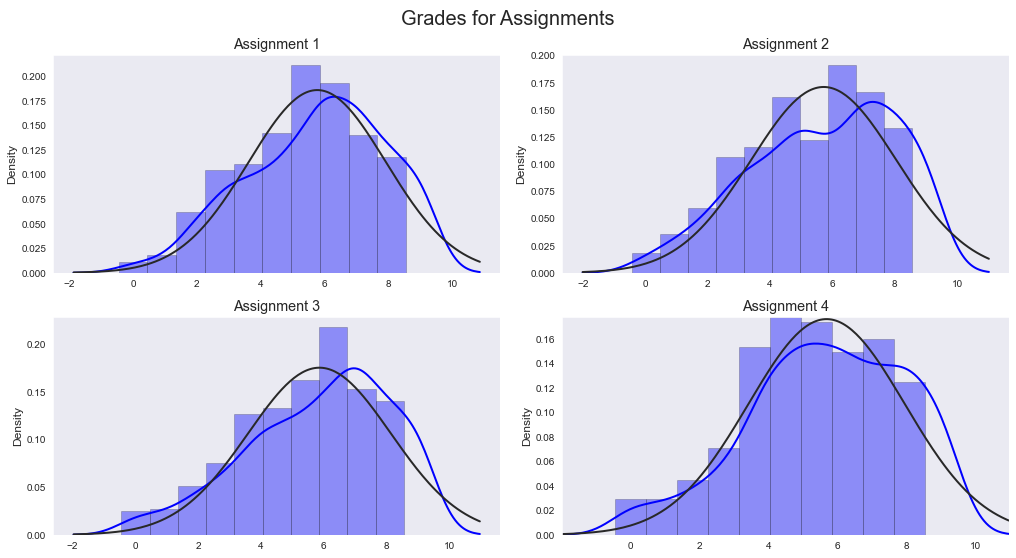

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(14, 14))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(4):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Assignment[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Assignment {_+1}")
fig.suptitle('Grades for Assignments', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Mid-Terms 

In [7]:
Mid_term = dict()
for _ in range(1, 3):
    Mid_term[_] = grades(0, 100, 75, 20)
for key, item in Mid_term.items():
    print(f"Mid-Term {key} -> {item[:10]}")

Mid-Term 1 -> [90, 47, 89, 62, 42, 69, 88, 55, 49, 60]
Mid-Term 2 -> [65, 62, 64, 34, 71, 51, 81, 55, 49, 85]


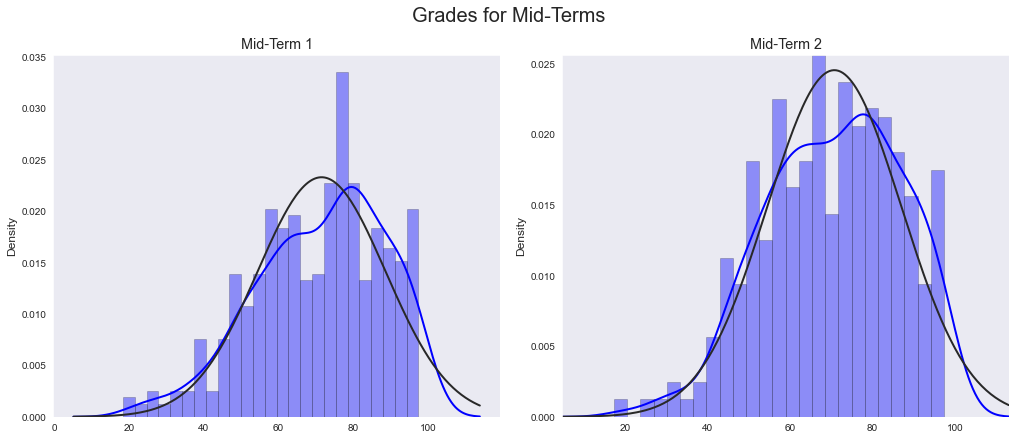

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
grid = gs(nrows=1, ncols=2, figure=fig)
for _ in range(2):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Mid_term[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=25)
    ax.set_title(f"Mid-Term {_+1}")
fig.suptitle('Grades for Mid-Terms', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Final Exam

In [9]:
Final = grades(0, 100, 65, 25)
print(f"Final Exam -> {Final[:10]}")

Final Exam -> [74, 14, 97, 46, 73, 62, 43, 38, 56, 48]


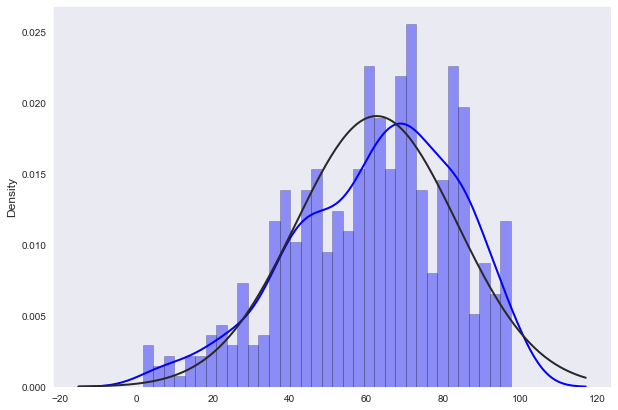

In [10]:
plt.figure(figsize=(10, 7))
sns.distplot(Final, fit=ss.norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=35)
plt.show()

### Grade Weights 
Each type of test will contribute this much to the final grade:
* Final Exam = 30%
* Mid-Terms = 30%
* Assignments = 20%
* Labs = 20%

Total passing percentage is assumed to be **60%**

### Making the DataFrame 
#### Combining the marks togethe

In [11]:
df = pd.DataFrame(index=range(1, n+1))
df.index.name = 'Student'

# automate the process of inputting the grades for all tests for each student
for _ in range(1, 9):
    df[f"Lab {_}"] = Lab[_]

for _ in range(1, 5):
    df[f"Assignment {_}"] = Assignment[_]
    
for _ in range(1, 3):
    df[f"Mid-Term {_}"] = Mid_term[_]
    
df['Final'] = Final
    
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final
Student,,,,,,,,,,,,,,,
1,5,5,7,9,5,1,8,4,5,8,8,6,90,65,74
2,6,4,5,3,5,5,7,8,5,3,7,5,47,62,14
3,9,9,5,7,6,9,3,6,2,7,6,7,89,64,97
4,6,3,8,7,4,6,9,4,6,8,8,3,62,34,46
5,4,5,5,9,2,5,0,5,6,4,4,5,42,71,73


In [12]:
print(f"No. of students -> {len(df)}\nNumber of tests -> {df.shape[1]}")

No. of students -> 500
Number of tests -> 15


#### Determining if a student passes

In [13]:
Final_percent = 0.3
Mid_term_percent = 0.3
Assignments_percent = 0.2
Labs_percent = 0.2

Calculate the total grade for each category of test, then use that total and calculate the overall percentage of how much it contributes to students (based on the test's weightage) **overall** grade

In [14]:
lab_grades = list(df.iloc[:, :8].apply(lambda x: np.sum(x) / 80, axis=1) * Labs_percent)
assignment_grades = list(df.iloc[:, 8:12].apply(lambda x: np.sum(x) / 40, axis=1) * Assignments_percent)
mid_term_grades = list(df.iloc[:, 12:14].apply(lambda x: np.sum(x) / 200, axis=1) * Mid_term_percent)
final_grades = list(df.Final.apply(lambda x: (x / 100) * Final_percent))
lab_grades[:10]

[0.11000000000000001,
 0.1075,
 0.135,
 0.11750000000000001,
 0.08750000000000001,
 0.1,
 0.1,
 0.11499999999999999,
 0.11000000000000001,
 0.12]

In [15]:
overall_grades = [] # calculate the total grade percentage
for _ in range(n):
    overall_grades.append(np.round((lab_grades[_] + assignment_grades[_] + mid_term_grades[_] + final_grades[_]) * 100, 2))
overall_grades[:10]

[69.95, 41.3, 76.55, 52.45, 57.1, 58.6, 57.75, 49.4, 57.0, 59.65]

#### Finishing the final table 

In [16]:
df['Total'] = overall_grades
df['Pass/Fail'] = ["Pass" if x > 60 else "Fail" for x in overall_grades]
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,5,5,7,9,5,1,8,4,5,8,8,6,90,65,74,69.95,Pass
2,6,4,5,3,5,5,7,8,5,3,7,5,47,62,14,41.30,Fail
3,9,9,5,7,6,9,3,6,2,7,6,7,89,64,97,76.55,Pass
4,6,3,8,7,4,6,9,4,6,8,8,3,62,34,46,52.45,Fail
5,4,5,5,9,2,5,0,5,6,4,4,5,42,71,73,57.10,Fail


In [17]:
print(f"Students failed -> {len(df[df['Pass/Fail'] == 'Fail'])}\nStudents passed -> {len(df[df['Pass/Fail'] == 'Pass'])}")

Students failed -> 175
Students passed -> 325


In [18]:
df.describe().drop(['count', '25%', '50%', '75%'])

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total
mean,5.702000,5.836000,5.732000,5.646000,5.876000,5.642000,5.766000,5.792000,5.770000,5.71800,5.862000,5.684000,71.516000,70.792000,62.580000,63.135200
std,2.306477,2.171298,2.265047,2.255406,2.209613,2.325651,2.355066,2.167518,2.149032,2.33439,2.278011,2.267692,17.132331,16.258087,20.944999,8.292463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,20.000000,19.000000,3.000000,39.150000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000,9.000000,99.000000,99.000000,99.000000,83.900000


### Creating excel file 

In [19]:
df.to_excel("Grades.xlsx", sheet_name='Grades')

### Making the Classifier 
#### Preprocessing

In [20]:
df_cf = df.copy()
df_cf.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,5,5,7,9,5,1,8,4,5,8,8,6,90,65,74,69.95,Pass
2,6,4,5,3,5,5,7,8,5,3,7,5,47,62,14,41.30,Fail
3,9,9,5,7,6,9,3,6,2,7,6,7,89,64,97,76.55,Pass
4,6,3,8,7,4,6,9,4,6,8,8,3,62,34,46,52.45,Fail
5,4,5,5,9,2,5,0,5,6,4,4,5,42,71,73,57.10,Fail


In [21]:
df_cf_y = LabelEncoder().fit_transform(df_cf['Pass/Fail'])
df_cf.drop(['Final', 'Total', 'Pass/Fail'], axis=1, inplace=True)
scaler = StandardScaler().fit(df_cf)
df_cf_x = scaler.transform(df_cf)
df_cf_x[0]

array([-0.30466512, -0.38540883,  0.56037249,  1.48858279, -0.39684659,
       -1.99799912,  0.94954332, -0.82758024, -0.35865977,  0.9785365 ,
        0.93947795,  0.13948826,  1.0799763 , -0.35661027])

In [22]:
df_cf_x_train, df_cf_x_test, df_cf_y_train, df_cf_y_test = train_test_split(df_cf_x, df_cf_y, stratify=df_cf_y, 
                                                                           test_size=.15, random_state=7)
print(f"Train X -> {df_cf_x_train.shape}\nTrain y -> {df_cf_y_train.shape}")
print(f"Test X -> {df_cf_x_test.shape}\nTest y -> {df_cf_y_test.shape}")

Train X -> (425, 14)
Train y -> (425,)
Test X -> (75, 14)
Test y -> (75,)


#### Setting up the models
##### RandomForestClassifier

In [23]:
rfc = RandomizedSearchCV(estimator=RandomForestClassifier(),
                  param_distributions={'n_estimators':range(500, 1050, 100), 
                                       'warm_start':[True], 'criterion':['gini', 'entropy']},
                  n_jobs=-1, cv=RepeatedStratifiedKFold(random_state=7), 
                  return_train_score=True, verbose=3, n_iter=100, refit=True)
rfc.fit(df_cf_x_train, df_cf_y_train)
rfc.best_params_

Fitting 50 folds for each of 12 candidates, totalling 600 fits


{'warm_start': True, 'n_estimators': 800, 'criterion': 'gini'}

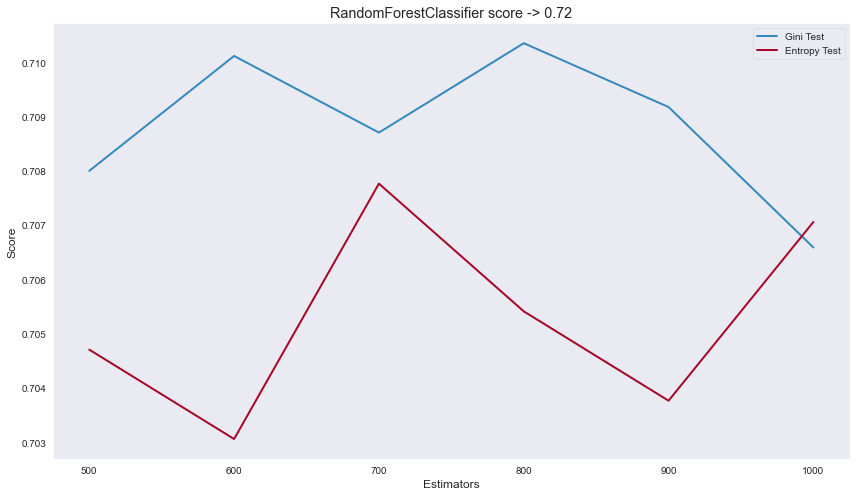

In [24]:
plt.figure(figsize=(12, 7))
plt.title(f"RandomForestClassifier score -> {rfc.score(df_cf_x_test, df_cf_y_test)}")
plt.plot(range(500, 1050, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'gini'], 
         label='Gini Test')
plt.plot(range(500, 1050, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'entropy'], 
         label='Entropy Test')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### LogisticRegressionCV 

In [25]:
logreg = LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_splits=10, random_state=7), 
                             max_iter=1000, n_jobs=-1, verbose=3, refit=True, random_state=7).fit(df_cf_x_train, 
                                                                                                  df_cf_y_train)
logreg.score(df_cf_x_test, df_cf_y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


0.7333333333333333

##### KNeighborsClassifier

In [26]:
knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions={'n_neighbors':range(1, 16), 
                                                                'weights':['uniform', 'distance'], 
                                                                'n_jobs':[-1]}, 
                  cv=RepeatedStratifiedKFold(random_state=7), n_jobs=-1, return_train_score=True, 
                         verbose=3, refit=True, n_iter=100)
knn.fit(df_cf_x_train, df_cf_y_train)
knn.best_params_

Fitting 50 folds for each of 30 candidates, totalling 1500 fits


{'weights': 'uniform', 'n_neighbors': 14, 'n_jobs': -1}

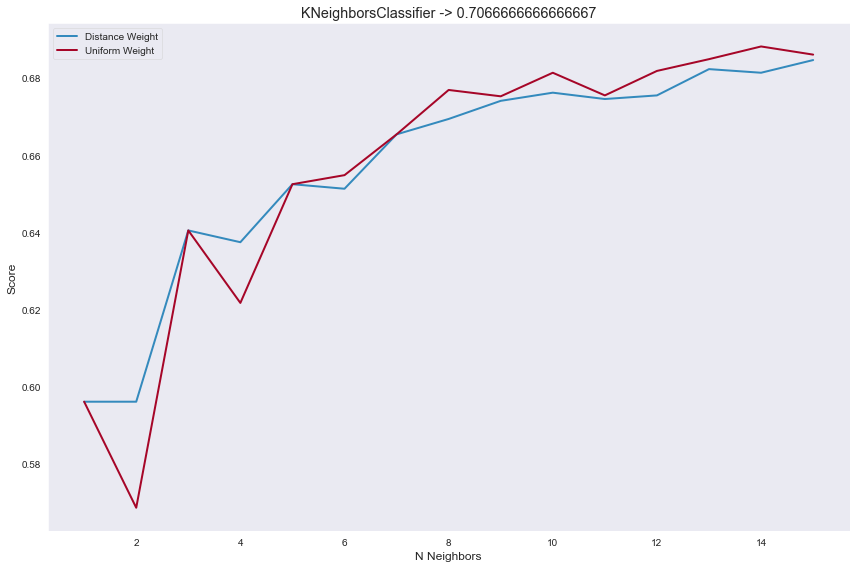

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 16), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'distance'],
        label='Distance Weight')
plt.plot(range(1, 16), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'uniform'], 
        label='Uniform Weight')
plt.title(f"KNeighborsClassifier -> {knn.score(df_cf_x_test, df_cf_y_test)}")
plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### Naive-Bayes Classifier 

In [28]:
gnb = GaussianNB().partial_fit(df_cf_x_train, df_cf_y_train, np.unique(df_cf_y_train))
gnb.score(df_cf_x_test, df_cf_y_test)

0.7333333333333333

##### Decision Tree Classifier

In [29]:
dtc = DecisionTreeClassifier(criterion='entropy').fit(df_cf_x_train, df_cf_y_train)
dtc.score(df_cf_x_test, df_cf_y_test)

0.64

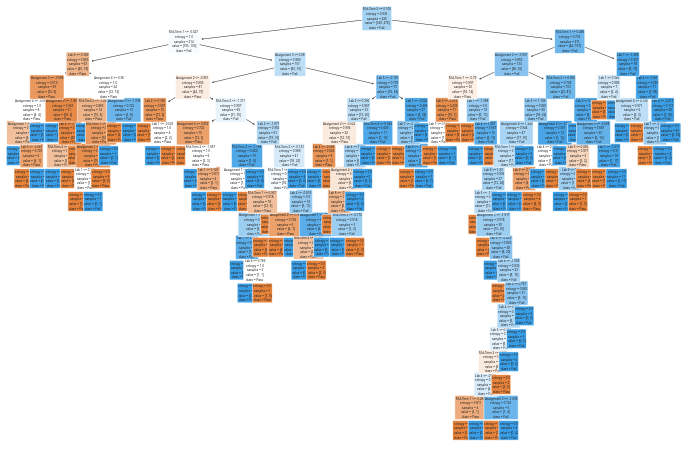

In [30]:
fig = plt.figure(figsize=(12, 8))
dtc_tree = tree.plot_tree(dtc, feature_names=df_cf.columns, class_names=['Pass', 'Fail'], filled=True, rounded=True,
                         fontsize=3)

##### Gradient Boosting Classifier

In [31]:
gbc = GradientBoostingClassifier(n_estimators=1000, max_depth=4, random_state=7, verbose=3, warm_start=True,
                                n_iter_no_change=10).fit(df_cf_x_train, df_cf_y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2234            1.00s
         2           1.1644            1.50s
         3           1.1153            1.33s
         4           1.0628            1.25s
         5           1.0215            1.20s
         6           0.9821            1.16s
         7           0.9427            1.28s
         8           0.9103            1.24s
         9           0.8774            1.32s
        10           0.8489            1.29s
        11           0.8237            1.35s
        12           0.8000            1.32s
        13           0.7772            1.37s
        14           0.7493            1.34s
        15           0.7308            1.31s
        16           0.7071            1.35s
        17           0.6895            1.33s
        18           0.6684            1.36s
        19           0.6521            1.34s
        20           0.6343            1.32s
        21           0.6177            1.35s


In [32]:
gbc.score(df_cf_x_test, df_cf_y_test)

0.6666666666666666

####  Evaluating models

In [33]:
models = pd.DataFrame(index=['RandomForestClassifier', 'LogisticRegressionCV', 'KNeighborsClassifier', 
                      'GaussianNB', 'DecisionTreeClassifier', 'GradientBoosting'])
models.index.name="Algorithms"
models['Score'] = np.round([rfc.score(df_cf_x_test, df_cf_y_test), logreg.score(df_cf_x_test, df_cf_y_test), 
                  knn.score(df_cf_x_test, df_cf_y_test), gnb.score(df_cf_x_test, df_cf_y_test), 
                  dtc.score(df_cf_x_test, df_cf_y_test), gbc.score(df_cf_x_test, df_cf_y_test)], 4) * 100
models['f1 Score'] = np.round([f1_score(df_cf_y_test, rfc.predict(df_cf_x_test)), 
                      f1_score(df_cf_y_test, logreg.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, knn.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gnb.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, dtc.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gbc.predict(df_cf_x_test))], 4) * 100
models['Used Model'] = [rfc, logreg, knn, gnb, dtc, gbc]
models = models.sort_values(["Score", 'f1 Score'], ascending=False)
models

,Score,f1 Score,Used Model
Algorithms,,,
LogisticRegressionCV,73.33,81.82,LogisticRegressionCV(cv=RepeatedStratifiedKFol...
GaussianNB,73.33,81.48,GaussianNB()
RandomForestClassifier,72.00,81.08,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
KNeighborsClassifier,70.67,79.63,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
GradientBoosting,66.67,77.48,([DecisionTreeRegressor(criterion='friedman_ms...
DecisionTreeClassifier,64.00,72.73,DecisionTreeClassifier(criterion='entropy')


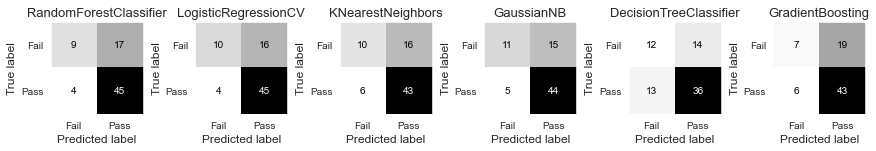

In [34]:
models_list = [rfc, logreg, knn, gnb, dtc, gbc]
model_names = ['RandomForestClassifier', 'LogisticRegressionCV', 'KNearestNeighbors', 'GaussianNB', 
              'DecisionTreeClassifier', 'GradientBoosting']
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gs(nrows=1, ncols=len(models), figure=fig)
for _ in range(len(models)):
    ax = fig.add_subplot(grid[_])
    plot_confusion_matrix(models_list[_], df_cf_x_test, df_cf_y_test, labels=[0, 1],
                         display_labels=['Fail', 'Pass'], colorbar=False, ax=ax, cmap='binary')
    plt.title(f"{model_names[_]}", fontsize=13)
    
plt.show()

### Example 

In [35]:
Lab_1 = 7
Lab_2 = 6
Lab_3 = 6
Lab_4 = 4
Lab_5 = 6
Lab_6 = 8
Lab_7 = 5
Lab_8 = 3

Asgn_1 = 6
Asgn_2 = 4
Asgn_3 = 4
Asgn_4 = 5

MT_1 = 60
MT_2 = 55

test = [Lab_1, Lab_2, Lab_3, Lab_4, Lab_5, Lab_6, Lab_7, Lab_8,
       Asgn_1, Asgn_2, Asgn_3, Asgn_4,
       MT_1, MT_2]

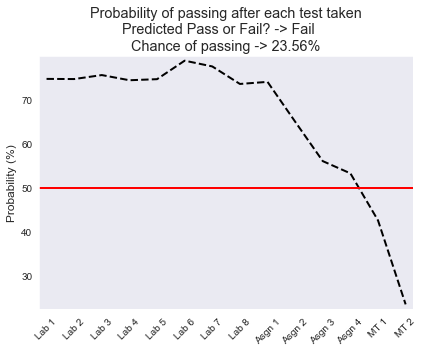

'Thank you for using this program!'

In [36]:
def calculate(test):
    test = scaler.transform(np.array(test).reshape(1, -1)) # scaling scores 
    
    test_ = [0] * len(test[0]) # making dummy list to cummulatively add each test score
    probabs = [] # to store each probability as each test score gets entered
    for x in range(len(test[0])):
        test_[x] = test[0][x]
        probabs.append(models.iloc[0]['Used Model'].predict_proba(np.array([test_]))[0][1] * 100)
    
    pf = None
    if models.iloc[0]['Used Model'].predict(test) == 0:
        pf = 'Fail'
    else:
        pf = 'Pass'
        
    plt.figure(figsize=(6,5))
    plt.title(f"Probability of passing after each test taken\nPredicted Pass or Fail? -> {pf}\
    \nChance of passing -> {models.iloc[0]['Used Model'].predict_proba(test)[0][1] * 100:.2f}%")
    plt.plot(['Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Lab 8',
             'Asgn 1', 'Asgn 2', 'Asgn 3', 'Asgn 4',
             'MT 1', 'MT 2'], probabs, c='black', linestyle='--')
    plt.axhline(50, color='red')
    plt.xticks(rotation=45)
    plt.ylabel('Probability (%)')
    plt.margins(0.02, 0.02)
    plt.tight_layout()
    plt.show()
    
    return 'Thank you for using this program!'
calculate(test)

### Experimenting Neural Network

In [270]:
def neural_classifier():
    model = Sequential([Dense(64, input_dim=14), Activation('relu'),
                        Dense(32), Activation('relu'),
                       Dense(1), Activation('sigmoid')])
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy', metric.BinaryAccuracy()])
    return model

In [271]:
early_stopping = EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=10, 
                                                  mode='max', restore_best_weights=True)
nn_clf = KerasClassifier(build_fn=neural_classifier, epochs=50, batch_size=64, verbose=1, 
                         use_multiprocessing=True)
nn_clf.fit(df_cf_x_train, df_cf_y_train, shuffle=False, 
           validation_data=(df_cf_x_test, df_cf_y_test), callbacks=early_stopping)

Epoch 1/50
7/7 [==============================] - 0s 21ms/step - loss: 0.7548 - accuracy: 0.4060 - binary_accuracy: 0.4060 - val_loss: 0.7316 - val_accuracy: 0.4400 - val_binary_accuracy: 0.4400
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5317 - binary_accuracy: 0.5317 - val_loss: 0.6820 - val_accuracy: 0.5733 - val_binary_accuracy: 0.5733
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6428 - accuracy: 0.6688 - binary_accuracy: 0.6688 - val_loss: 0.6515 - val_accuracy: 0.6000 - val_binary_accuracy: 0.6000
Epoch 4/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6127 - accuracy: 0.6636 - binary_accuracy: 0.6636 - val_loss: 0.6329 - val_accuracy: 0.6533 - val_binary_accuracy: 0.6533
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.5903 - accuracy: 0.6635 - binary_accuracy: 0.6635 - val_loss: 0.6200 - val_accuracy: 0.6533 - val_binary_accuracy: 0.6533
Epoch 6/50
7/7 [=============

In [272]:
print("f1_score =", f1_score(df_cf_y_test, nn_clf.predict(df_cf_x_test)))
print("Accuracy =", nn_clf.score(df_cf_x_test, df_cf_y_test))

2/2 [==============================] - 0s 1ms/step
f1_score = 0.8113207547169812
2/2 [==============================] - 0s 2ms/step - loss: 0.5567 - accuracy: 0.7333 - binary_accuracy: 0.7333
Accuracy = 0.7333333492279053


In [273]:
print(f"Neural Network probability of passing -> \
    {nn_clf.predict_proba(scaler.transform(np.array(test).reshape(1, -1)))[0][1]*100:.2f}%")

1/1 [==============================] - 0s 10ms/step
Neural Network probability of passing ->     36.98%


In [274]:
neural_classifier().summary()

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_343 (Dense)            (None, 64)                960       
_________________________________________________________________
activation_343 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_344 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_344 (Activation)  (None, 32)                0         
_________________________________________________________________
dense_345 (Dense)            (None, 1)                 33        
_________________________________________________________________
activation_345 (Activation)  (None, 1)                 0         
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
__________________________________________________